In [23]:
#jupyter url: http://127.0.0.1:8888/tree?token=ecf2b449a6a9ef419978fb98f5824d2417333aa62eacd254

In [24]:
%cd /home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
!ls

/home/luzinsan/Documents/Obsidian/ML/Innopolis/material/1 semester/Machine Learning/Project/notebooks
data-profiling.ipynb  orders.ipynb


In [25]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from category_encoders import BinaryEncoder, cat_boost
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Reading from database and prepare target feature

In [27]:
from sqlalchemy import create_engine, text

session_engine = create_engine('sqlite:///../F24.ML.Assignment.One.data.db')

with session_engine.connect() as conn: 
    original_orders = pd.read_sql_query(text('SELECT * FROM joined_table'), con=conn) 
    
original_orders.to_csv('../content/full_orders_df.csv', index=False)
original_orders

,store_id,order_id,profit,delivery_distance,date_create,order_start_prepare,planned_prep_time,order_ready,order_pickup,region_id,status_id
0,5014,20562761,45.504,2205,2024-09-05 15:25:25,2024-09-05 15:25:33,15.0,2024-09-05 15:32:00,05-09-2024 16:00:00,683,F
1,3856,20562753,30.336,1368,2024-09-05 15:25:12,2024-09-05 15:25:19,10.0,2024-09-05 15:35:50,05-09-2024 16:03:50,683,F
2,10825,20562723,43.608000000000004,459,2024-09-05 15:23:32,2024-09-05 15:23:44,20.0,2024-09-05 15:38:38,05-09-2024 16:06:38,683,F
3,5640,20562673,32.864,2611,2024-09-05 15:19,2024-09-05 15:19:05,20.0,2024-09-05 15:35:25,05-09-2024 16:03:25,709,F
4,7283,20562665,11.06,1041,2024-09-05 15:18:39,None,15.0,2024-09-05 15:35:33,05-09-2024 16:03:33,707,F
...,...,...,...,...,...,...,...,...,...,...,...
517605,9007,18671231,122.73440000000001,5411,2024-05-08 00:02:22,2024-05-08 00:02:37,25.0,2024-05-08 00:36:25,08-05-2024 01:04:25,707,F
517606,8929,18671229,40.29,5499,2024-05-08 00:02:59,2024-05-08 00:10:07,30.0,2024-05-08 00:22:04,08-05-2024 00:50:04,683,F
517607,8721,18671227,6.0040000000000004,4396,2024-05-08 00:01:38,2024-05-08 00:01:50,20.0,2024-05-08 00:49:19,08-05-2024 01:17:19,691,F
517608,5863,18671225,15.8,560,2024-05-08 00:01:46,2024-05-08 00:02:01,15.0,2024-05-08 00:10:29,08-05-2024 00:38:29,703,F


In [26]:
print("Observations with None in 'date_create' and 'order_start_prepare': ", (orders['date_create'].isnull() \
                                                                              & orders['order_start_prepare'].isnull()).sum(), 
      "\nWill be drop in the next line")
orders = orders[~(orders['date_create'].isnull() & orders['order_start_prepare'].isnull())]
orders.shape

(517582, 11)

In [27]:
orders['order_start_prepare'] = pd.to_datetime(orders['order_start_prepare'])

In [28]:
print("Observations with None in 'date_create' and 'order_start_prepare': ", (orders['date_create'].isnull() \
                                                                              & orders['order_start_prepare'].isnull()).sum(), 
      "\nWill be drop in the next line")
orders = orders[~(orders['date_create'].isnull() & orders['order_start_prepare'].isnull())]
orders.shape

Observations with None in 'date_create' and 'order_start_prepare':  28 
Will be drop in the next line


(517582, 13)

In [30]:
def impute_dates_by_store(x):
    diff_date = x['order_start_prepare'] - x['date_create']
    mean_diff = diff_date[diff_date > pd.to_timedelta("0 days")].mean()
    x.loc[x['order_start_prepare'].isnull(), 'order_start_prepare'] = x.loc[x['order_start_prepare'].isnull(), 'date_create'] + mean_diff
    x.loc[x['date_create'].isnull(), 'date_create'] = x.loc[x['date_create'].isnull(), 'order_start_prepare'] - mean_diff

    diff_date = x['order_pickup'] - x['order_ready']
    mean_diff = diff_date[diff_date > pd.to_timedelta("0 days")].mean()
    x.loc[x['order_pickup'].isnull(), 'order_pickup'] = x.loc[x['order_pickup'].isnull(), 'order_ready'] + mean_diff
    x.loc[x['order_ready'].isnull(), 'order_ready'] = x.loc[x['order_ready'].isnull(), 'order_pickup'] - mean_diff
    return x

orders.loc[:,['date_create','order_start_prepare','order_ready','order_pickup']] = orders.groupby("store_id")\
        .apply(lambda x: impute_dates_by_store(x))\
        .reset_index(allow_duplicates=True)\
        .set_index('level_1')[['date_create','order_start_prepare','order_ready','order_pickup']]


In [31]:
orders.loc[:, 'actual_prep_time'] = (orders['order_ready'] - orders['order_start_prepare']).dt.total_seconds() /60

anomaly_diff_mask = (orders['actual_prep_time'] < 0) | orders['actual_prep_time'].isnull() 
print(orders.loc[anomaly_diff_mask].shape)
orders = orders.loc[~anomaly_diff_mask]

(2518, 14)


In [32]:
def encode_cyclical_feat(data: pd.DataFrame, col: pd.Series, col_name: str):
    data[col_name + '_sin'] = np.sin(2 * np.pi * col/col.max())
    data[col_name + '_cos'] = np.cos(2 * np.pi * col/col.max())
    return data


for col_name in ['date_create', 'order_start_prepare']:
    orders = encode_cyclical_feat(orders, orders[col_name].dt.month, col_name + '_month')
    orders = encode_cyclical_feat(orders, orders[col_name].dt.day, col_name + '_day')
    orders = encode_cyclical_feat(orders, orders[col_name].dt.weekday, col_name + '_weekday')
    orders = encode_cyclical_feat(orders, orders[col_name].dt.hour, col_name + '_hour')
    orders = encode_cyclical_feat(orders, orders[col_name].dt.minute, col_name + '_minute')

    orders = orders.drop(columns=col_name)

orders = orders.drop(columns=['order_id','order_ready','order_pickup'])

<Axes: ylabel='actual_prep_time'>

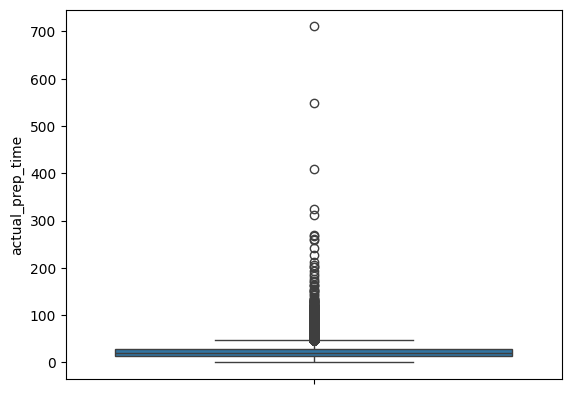

In [33]:
sns.boxplot(orders['actual_prep_time'])

In [34]:
orders.to_csv('../content/orders_with_target.csv', index=False)

In [35]:
orders

,store_id,products,order_price,profit,delivery_distance,planned_prep_time,region_id,status_id,actual_prep_time,date_create_month_sin,...,order_start_prepare_month_sin,order_start_prepare_month_cos,order_start_prepare_day_sin,order_start_prepare_day_cos,order_start_prepare_weekday_sin,order_start_prepare_weekday_cos,order_start_prepare_hour_sin,order_start_prepare_hour_cos,order_start_prepare_minute_sin,order_start_prepare_minute_cos
0,5014,2,56.880,45.504,2205,15.0,683,F,6.450000,-2.449294e-16,...,-2.449294e-16,1.000000,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.461093,-0.887352
1,3856,2,60.672,30.336,1368,10.0,683,F,10.516667,-2.449294e-16,...,-2.449294e-16,1.000000,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.461093,-0.887352
2,10825,1,54.510,43.608000000000004,459,20.0,683,F,14.900000,-2.449294e-16,...,-2.449294e-16,1.000000,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.638244,-0.769834
3,5640,2,41.080,32.864,2611,20.0,709,F,16.333333,-2.449294e-16,...,-2.449294e-16,1.000000,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.899312,-0.437307
4,7283,1,22.120,11.06,1041,15.0,707,F,15.272624,-2.449294e-16,...,-2.449294e-16,1.000000,0.848644,0.528964,1.224647e-16,-1.0,-0.81697,-0.57668,0.847734,-0.530421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517605,9007,3,153.418,122.73440000000001,5411,25.0,707,F,33.800000,-3.420201e-01,...,-3.420201e-01,-0.939693,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.211383,0.977403
517606,8929,4,80.580,40.29,5499,30.0,683,F,11.950000,-3.420201e-01,...,-3.420201e-01,-0.939693,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.874763,0.484551
517607,8721,1,30.020,6.0040000000000004,4396,20.0,691,F,47.483333,-3.420201e-01,...,-3.420201e-01,-0.939693,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.106293,0.994335
517608,5863,1,31.600,15.8,560,15.0,703,F,8.466667,-3.420201e-01,...,-3.420201e-01,-0.939693,0.998717,-0.050649,8.660254e-01,-0.5,0.00000,1.00000,0.211383,0.977403


In [29]:
orders['date_create'] = pd.to_datetime(orders['date_create'], format='mixed')

# Baseline

In [ ]:
df = pd.read_csv('../content/orders_with_target.csv')
df.sample(10)

,store_id,products,order_price,profit,delivery_distance,planned_prep_time,region_id,status_id,actual_prep_time,date_create_month_sin,...,order_start_prepare_month_sin,order_start_prepare_month_cos,order_start_prepare_day_sin,order_start_prepare_day_cos,order_start_prepare_weekday_sin,order_start_prepare_weekday_cos,order_start_prepare_hour_sin,order_start_prepare_hour_cos,order_start_prepare_minute_sin,order_start_prepare_minute_cos
167907,8455,7,66.914,57.0072,17990,20.0,693,F,5.316667,-0.984808,...,-0.984808,0.173648,-0.571268,0.820763,-2.449294e-16,1.0,-1.361666e-01,-0.990686,0.552800,-0.833314
288286,5567,1,87.690,43.8450,11152,30.0,685,F,32.450000,-0.984808,...,-0.984808,0.173648,0.201299,0.979530,0.000000e+00,1.0,0.000000e+00,1.000000,0.899312,-0.437307
145288,3196,2,28.440,14.2200,1581,20.0,683,F,5.554784,-0.642788,...,-0.642788,0.766044,0.394356,0.918958,-8.660254e-01,-0.5,-3.984011e-01,-0.917211,0.971430,-0.237327
321793,10309,3,62.410,65.0960,8375,25.0,691,F,35.900000,-0.866025,...,-0.866025,-0.500000,-0.998717,-0.050649,-2.449294e-16,1.0,0.000000e+00,1.000000,0.957422,0.288692
107995,8283,8,140.541,39.4842,6976,30.0,683,F,21.216667,-0.642788,...,-0.642788,0.766044,0.897805,-0.440394,-8.660254e-01,0.5,-9.976688e-01,-0.068242,-0.461093,-0.887352
229088,7701,1,126.400,63.2000,3799,15.0,683,F,12.045424,-0.984808,...,-0.984808,0.173648,0.299363,-0.954139,-2.449294e-16,1.0,-8.878852e-01,0.460065,0.000000,1.000000
105440,3141,3,61.620,40.6850,3400,10.0,695,F,4.650000,-0.642788,...,-0.642788,0.766044,0.790776,-0.612106,-2.449294e-16,1.0,-1.361666e-01,-0.990686,0.596367,0.802712
434733,3136,4,48.980,74.5760,5666,20.0,693,F,11.644656,-0.342020,...,-0.342020,-0.939693,-0.848644,0.528964,-2.449294e-16,1.0,-8.169699e-01,-0.576680,0.678312,0.734774
441135,3376,2,101.910,50.9550,15841,35.0,683,F,33.179129,-0.342020,...,-0.342020,-0.939693,-0.988468,0.151428,-8.660254e-01,-0.5,-2.449294e-16,1.000000,0.899312,-0.437307
407597,3338,5,105.070,26.5440,1829,50.0,683,F,23.833333,-0.866025,...,-0.866025,-0.500000,0.394356,0.918958,-2.449294e-16,1.0,0.000000e+00,1.000000,-0.106293,0.994335


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515064 entries, 0 to 515063
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   store_id                         515064 non-null  int64  
 1   products                         515064 non-null  int64  
 2   order_price                      500179 non-null  float64
 3   profit                           463932 non-null  float64
 4   delivery_distance                515064 non-null  int64  
 5   region_id                        515064 non-null  int64  
 6   status_id                        515064 non-null  object 
 7   actual_prep_time                 515064 non-null  float64
 8   date_create_month_sin            515064 non-null  float64
 9   date_create_month_cos            515064 non-null  float64
 10  date_create_day_sin              515064 non-null  float64
 11  date_create_day_cos              515064 non-null  float64
 12  da

In [ ]:
all_features = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'status_id', 'planned_prep_time', 'actual_prep_time', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos']

In [ ]:
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 
       'date_create_hour_cos',
       'order_start_prepare_hour_cos',
       'actual_prep_time']

In [5]:
df = df[feature_selected]

In [6]:
target = 'actual_prep_time'
cat_features = ['store_id','region_id']
numeric_features = df.columns.difference(cat_features + [target])
df[cat_features] = df[cat_features].astype('object') 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], 
                                                    train_size=0.7)

# Fill missing values
from sklearn.impute import SimpleImputer
col_imputing = ['order_price','profit']
imputer = SimpleImputer()
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)


encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

## Regression

Model intercept : 3.094044723021714
Model coefficient : [ 59.61843965  23.7025785   30.03875658   5.4854532   92.89483121
  -3.31974492  14.5925317  -15.14300027]
Mean Absolute Error: 6.8912027651194805
Mean Squared Error: 90.40607137490589
Root Mean Squared Error: 9.508210734670635
R^2: 0.3159702166587083


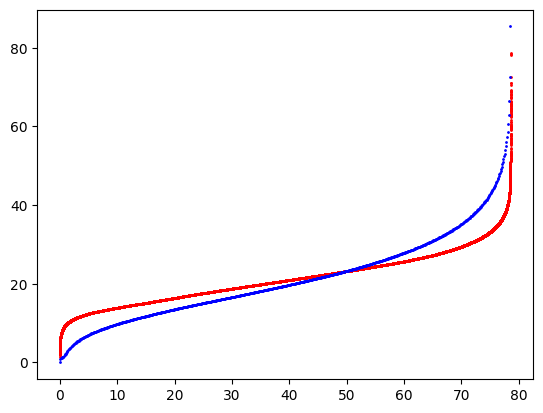

In [10]:
# With CatBoost Encoder and MinMax Scaler
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
print(f"Model intercept : {regressor.intercept_}")
print(f"Model coefficient : {regressor.coef_}")

y_pred = regressor.predict(X_test)
eval_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# With CatBoost Encoder and Robust Scaler
x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

In [32]:
orders['order_ready'] = pd.to_datetime(orders['order_ready'])

In [33]:
orders['order_pickup'] = pd.to_datetime(orders['order_pickup'], format='mixed')

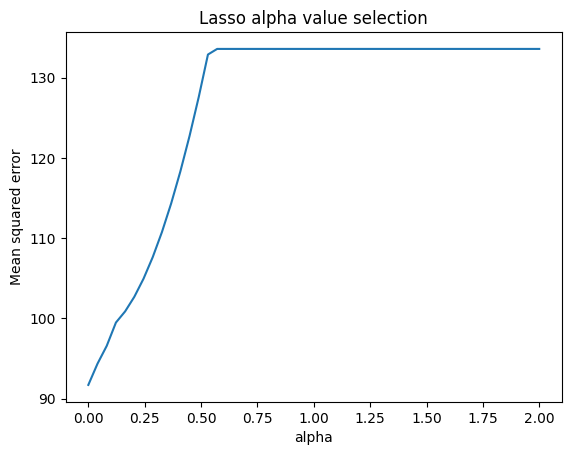

Best value of alpha: 1e-06


In [34]:
from sklearn.linear_model import Lasso
alphas = np.linspace(0.000001, 2, 50)
losses = []
for alpha in alphas:
    lasso = Lasso(alpha, random_state=42)
    lasso.fit(X_train, y_train)
    losses.append(metrics.mean_squared_error(y_test, lasso.predict(X_test)))
    
plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

In [10]:
alpha = best_alpha
lasso = Lasso(alpha, random_state=42)
lasso.fit(X_train, y_train)

y_pred = lasso.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

pd.Series(lasso.coef_, lasso.feature_names_in_)

Mean Absolute Error: 6.878960387787434
Mean Squared Error: 91.70546066828875
Root Mean Squared Error: 9.576296813919708
R^2: 0.3135079752733716


store_id                        64.268528
products                        27.105918
order_price                     31.248906
profit                           9.315187
delivery_distance               90.934206
region_id                       -3.951976
date_create_hour_cos            13.382453
order_start_prepare_hour_cos   -13.918576
dtype: float64

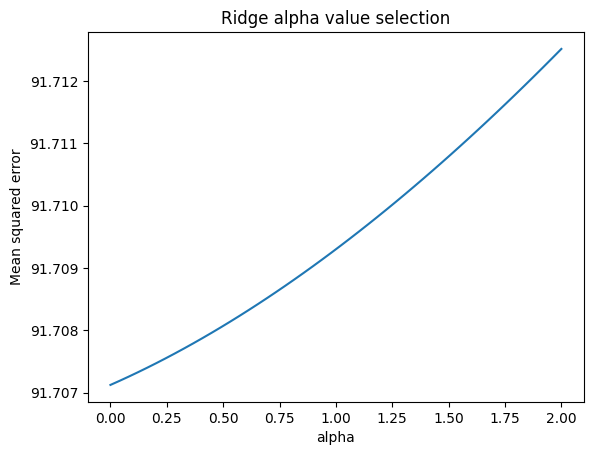

Best value of alpha: 1e-07
Mean Absolute Error: 6.879155572837975
Mean Squared Error: 91.70712451896478
Root Mean Squared Error: 9.576383686912548
R^2: 0.313495519960339


store_id                        64.274231
products                        27.105756
order_price                     31.270314
profit                           9.320754
delivery_distance               90.995999
region_id                       -3.953938
date_create_hour_cos            14.613668
order_start_prepare_hour_cos   -15.148441
dtype: float64

In [11]:
from sklearn.linear_model import Ridge
alphas = np.linspace(0.0000001, 2, 50)
losses = []
for alpha in alphas:
    ridge = Ridge(alpha, random_state=42)
    ridge.fit(X_train, y_train)
    losses.append(metrics.mean_squared_error(y_test, ridge.predict(X_test)))
   
    
plt.plot(alphas, losses)
plt.title("Ridge alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print("Best value of alpha:", best_alpha)

ridge = Ridge(best_alpha, random_state=42)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2:', metrics.r2_score(y_test, y_pred))

pd.Series(ridge.coef_, ridge.feature_names_in_)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures #to convert the original features into their higher order terms 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [13]:
degrees = [3]


for i in range(len(degrees)):
    polynomial_features = PolynomialFeatures(degree=degrees[i])

    linear_regression = LinearRegression()
   
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X_train, y_train.to_frame())

    
    y_pred = pipeline.predict(X_test)
    print("Polynomial degree: ", degrees[i])
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R^2:', metrics.r2_score(y_test, y_pred))



Polynomial degree:  3
Mean Absolute Error: 6.8460602705607165
Mean Squared Error: 90.93075296151088
Root Mean Squared Error: 9.535761792406042
R^2: 0.31930730999478996


,Actual,Predicted
0,26.900000,19.780567
1,11.050000,20.750941
2,47.256370,23.322831
3,25.500000,34.249243
4,25.683333,24.398443
...,...,...
154515,31.466667,25.653083
154516,29.900000,24.820187
154517,23.166667,32.243552
154518,23.966667,19.45319


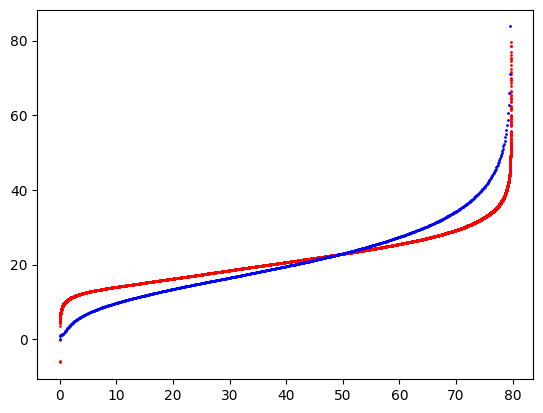

In [16]:
eval_df = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': pd.Series(y_pred.tolist()).explode()})

x_axis = np.linspace(0, eval_df['Predicted'].max(), len(eval_df))
plt.scatter(x_axis, eval_df['Predicted'].sort_values(), s=1, c='r')
plt.scatter(x_axis[::200], eval_df['Actual'].sort_values()[::200], s=1, c='b')
eval_df

In [17]:
mean_vector = np.mean(X_train, axis=0)
data_centered = X_train - mean_vector
data_centered

,store_id,products,order_price,profit,delivery_distance,region_id,date_create_hour_cos,order_start_prepare_hour_cos
0,0.000139,-0.020498,-0.018128,-0.013281,-0.003184,0.000491,-0.429159,-0.431672
1,0.000139,-0.020498,-0.021953,-0.008876,-0.008266,0.000491,-0.466069,-0.468581
2,0.000139,-0.053832,-0.018798,-0.005726,0.002549,-0.066300,0.515303,0.512791
3,0.000139,-0.020498,-0.005194,-0.018276,0.006219,-0.333624,-0.136631,-0.139144
4,0.000139,-0.020498,-0.006180,-0.018522,0.005103,-0.216487,0.262701,0.260189
...,...,...,...,...,...,...,...,...
360539,-0.094579,-0.020498,-0.022742,-0.020590,-0.002969,-0.119297,-0.466069,-0.468581
360540,0.155376,-0.053832,-0.025108,-0.017637,0.001190,0.016794,-0.429159,-0.360591
360541,0.100976,0.046168,0.012906,0.025932,0.008469,0.204957,-0.466069,-0.468581
360542,0.028584,-0.020498,-0.014461,-0.020590,-0.004958,0.016887,-0.136631,-0.139144


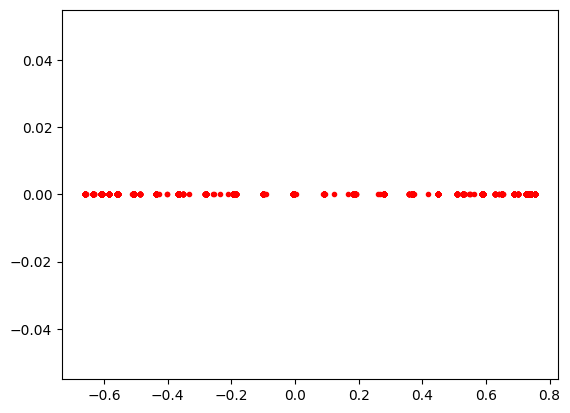

In [22]:
# this is to check your solution
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
x_PCA = pca.fit_transform(X_train)
plt.plot(x_PCA, np.zeros(len(x_PCA)), '.', color="red", label="Projected")

## Classification

In [83]:
df = pd.read_csv('../content/orders_with_target.csv')
df.columns

Index(['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'planned_prep_time', 'region_id', 'status_id', 'actual_prep_time',
       'date_create_month_sin', 'date_create_month_cos', 'date_create_day_sin',
       'date_create_day_cos', 'date_create_weekday_sin',
       'date_create_weekday_cos', 'date_create_hour_sin',
       'date_create_hour_cos', 'date_create_minute_sin',
       'date_create_minute_cos', 'order_start_prepare_month_sin',
       'order_start_prepare_month_cos', 'order_start_prepare_day_sin',
       'order_start_prepare_day_cos', 'order_start_prepare_weekday_sin',
       'order_start_prepare_weekday_cos', 'order_start_prepare_hour_sin',
       'order_start_prepare_hour_cos', 'order_start_prepare_minute_sin',
       'order_start_prepare_minute_cos'],
      dtype='object')

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515064 entries, 0 to 515063
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   store_id                         515064 non-null  int64  
 1   products                         515064 non-null  int64  
 2   order_price                      500179 non-null  float64
 3   profit                           463932 non-null  float64
 4   delivery_distance                515064 non-null  int64  
 5   planned_prep_time                515063 non-null  float64
 6   region_id                        515064 non-null  int64  
 7   status_id                        515064 non-null  object 
 8   actual_prep_time                 515064 non-null  float64
 9   date_create_month_sin            515064 non-null  float64
 10  date_create_month_cos            515064 non-null  float64
 11  date_create_day_sin              515064 non-null  float64
 12  da

In [84]:
df['on_time'] = np.where(abs(df['planned_prep_time'] - df['actual_prep_time']) <= 5, 1, 0)

In [61]:
# experiment #1
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 'date_create_month_sin',
       'date_create_month_cos', 'date_create_day_sin', 'date_create_day_cos',
       'date_create_weekday_sin', 'date_create_weekday_cos',
       'date_create_hour_sin', 'date_create_hour_cos',
       'date_create_minute_sin', 'date_create_minute_cos',
       'order_start_prepare_month_sin', 'order_start_prepare_month_cos',
       'order_start_prepare_day_sin', 'order_start_prepare_day_cos',
       'order_start_prepare_weekday_sin', 'order_start_prepare_weekday_cos',
       'order_start_prepare_hour_sin', 'order_start_prepare_hour_cos',
       'order_start_prepare_minute_sin', 'order_start_prepare_minute_cos', 'on_time']
df = df[feature_selected]

In [85]:
# experiment #2
feature_selected = ['store_id', 'products', 'order_price', 'profit', 'delivery_distance',
       'region_id', 
       'date_create_hour_cos',
       'order_start_prepare_hour_cos',
       'on_time']
df = df[feature_selected]

In [86]:
target = 'on_time'
cat_features = ['store_id','region_id']
numeric_features = df.columns.difference(cat_features + [target])
df[cat_features] = df[cat_features].astype('object') 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=target), 
                                                    df[target], 
                                                    train_size=0.7)

# Fill missing values
from sklearn.impute import SimpleImputer
col_imputing = ['order_price','profit']
imputer = SimpleImputer()
X_train[col_imputing] = pd.DataFrame(imputer.fit_transform(X_train[col_imputing]), columns=col_imputing, index=X_train.index)
X_test[col_imputing] = pd.DataFrame(imputer.transform(X_test[col_imputing]), columns=col_imputing, index=X_test.index)


encoder = cat_boost.CatBoostEncoder(cols=cat_features)
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test, y_test)

scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = pd.DataFrame(scaler.transform(X_test), columns=scaler.get_feature_names_out())

In [88]:
# Experiment #2
from sklearn.linear_model import LogisticRegression

# fit Logistic Regression
clf = LogisticRegression(random_state=42).fit(X_train, y_train)
y_test_pred = clf.predict(X_test)

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_test_pred)))

# Logistic Regression Coefficients
print("----Logistic Regression Coefficients----")
print(*[a for a in zip(list(X_train.columns), clf.coef_[0])], sep='\n')

Testing accuracy = 0.5754530157908362
Testing precision = 0.5444143700787402
Testing recall = 0.3196746181965295
----Logistic Regression Coefficients----
('store_id', np.float64(2.742044910123286))
('products', np.float64(-0.23386363144265376))
('order_price', np.float64(0.3444788199940395))
('profit', np.float64(0.22958510105157406))
('delivery_distance', np.float64(-0.3765424902022095))
('region_id', np.float64(0.5515448594919253))
('date_create_hour_cos', np.float64(0.11662196273674995))
('order_start_prepare_hour_cos', np.float64(-0.12583406714338902))


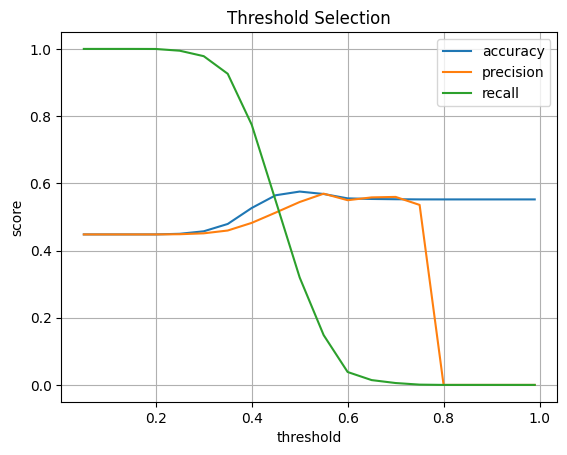

In [89]:
# TODO: calculate metrics for each threshold above and plot the result as below.
# thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
thresholds = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
pred_proba = clf.predict_proba(X_test)

results = [[],[],[]]
for i in thresholds:
    y_test_pred_thr = np.where(pred_proba[:, 1] > i, 1, 0)
    results[0].append(metrics.accuracy_score(y_test, y_test_pred_thr)) # accuracy 
    results[1].append(metrics.precision_score(y_test, y_test_pred_thr)) # precision
    results[2].append(metrics.recall_score(y_test, y_test_pred_thr)) # recall
    
plt.plot(thresholds, results[0], label = 'accuracy')   
plt.plot(thresholds, results[1], label = 'precision')   
plt.plot(thresholds, results[2], label = 'recall')
plt.title('Threshold Selection')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid()

Testing accuracy = 0.5265661403054621
Testing precision = 0.4822575711226675
Testing recall = 0.7744578173989684
Testing f1_score = 0.5943877975348891


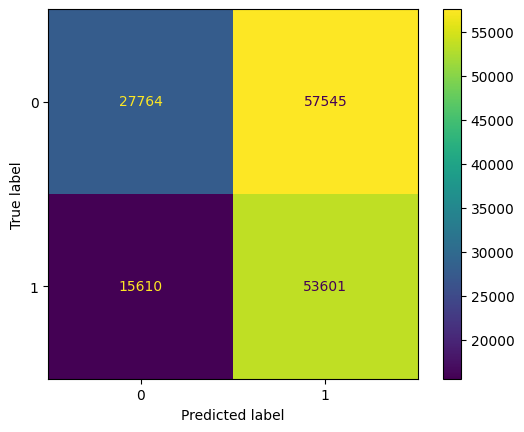

In [91]:
# Select the optimal prediction threshold
optimal_thresholds = 0.4

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


pred_proba = clf.predict_proba(X_test)
y_pred = np.where(pred_proba[:, 1] > optimal_thresholds, 1, 0)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_, 
                    #   normalize='true'
                      )
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

# calculate metrics
print('Testing accuracy = {}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Testing precision = {}'.format(metrics.precision_score(y_test, y_pred)))
print('Testing recall = {}'.format(metrics.recall_score(y_test, y_pred)))
print('Testing f1_score = {}'.format(metrics.f1_score(y_test, y_pred)))